Adjust the magnitudes of the galaxies to correct for
* which photometric survey they came from (there is an offset between BASS and DECals)
* ~~MW dust extinction (using Rongpu's new DESI E(B-V) map)~~ *This is now applied based on the Balmer decrement, in `TF_dustCorr.ipynb`*
* Doppler shift (a.k.a., $k$-correct)

In [1]:
import numpy as np

from astropy.table import Table
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u

import kcorrect.kcorrect

import ligo.skymap.plot
import matplotlib.pyplot as plt

# Data

## Galaxies

In [2]:
# gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/'
gals_directory = '/Users/kdouglass/Documents/Research/data/DESI/SV/'

gals_filename = 'SGA-2020_fuji_Vrot_photsys.fits'

gals = Table.read(gals_directory + gals_filename)

In [3]:
gals[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_err,TARGETID,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,int64,bytes1
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334321,15.531683,0.31152296,2.403034,4.429238,0.75814104,0,0.0224279674032048,2.44404472261522e-05,65.28941302448953,11.22724382461

## Dust map

From Rongpu's DESI paper *(insert reference once available)*

README: https://data.desi.lbl.gov/desi/users/rongpu/dust/desi_ebv/public_data/maps/README.txt

In [4]:
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'

ebv_filename = 'desi_ebv_gr_512.fits'

ebv_map = Table.read(ebv_directory + ebv_filename)

In [5]:
ebv_map_dict = {}

for i in range(len(ebv_map)):
    
    ebv_map_dict[ebv_map['HPXPIXEL'][i]] = i

In [6]:
ebv_map[:5]

HPXPIXEL,RA,DEC,N_STAR,EBV,EBV_ERR,DELTA_GR_WMEAN,DELTA_GR_WMEAN_ERR,DELTA_GR_MEAN,DELTA_GR_MEDIAN,EBV_SFD,FILL_FRAC
int32,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32
13708,104.63855421686748,82.41068335603913,1,0.049306054,0.013489795,0.05172205,0.014150795,0.05172205,0.05172205,0.05339464,0.045779493
13710,106.80722891566263,82.41068335603913,1,0.07093126,0.015191299,0.0744069,0.015935672,0.0744069,0.0744069,0.051478535,0.029138388
14042,105.53571428571428,82.31910944312953,3,0.0502533,0.008498142,0.05271571,0.008914551,0.049916025,0.0535412,0.05360793,0.0069751395
14045,108.75,82.31910944312953,1,0.061701782,0.02036462,0.06472517,0.021362487,0.06472517,0.06472517,0.046669774,0.025312508
14721,106.22093023255813,82.1359468197806,1,0.043066412,0.013557605,0.045176666,0.014221928,0.045176666,0.045176666,0.046965018,0.002364529


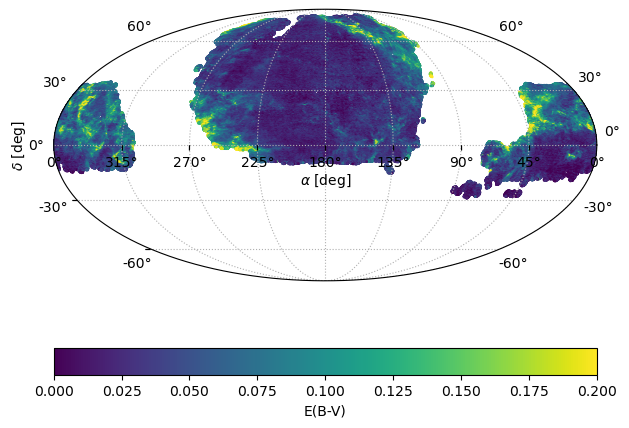

In [7]:
plt.figure(tight_layout=True)
ax = plt.subplot(111, projection='astro degrees mollweide')

plt.grid(linestyle=':')

plt.scatter(ebv_map['RA'], 
            ebv_map['DEC'], 
            s=1, 
            c=ebv_map['EBV'], 
            transform=ax.get_transform('world'), 
            vmin=0, 
            vmax=0.2)

plt.colorbar(location='bottom', label='E(B-V)')

ax.set_xlabel(r'$\alpha$ [deg]')
ax.set_ylabel(r'$\delta$ [deg]');

# MW dust extinction

Ratios of total to selective extinction (rederived from Schlafly11 and listed on https://www.legacysurvey.org/dr10/catalogs/#galactic-extinction-coefficients)

In [28]:
Rr = 2.165

In [29]:
# nside and order values are specific to the E(B-V) map used
hp = HEALPix(nside=512, order='ring', frame=ICRS())

## 1. Compute HEALPix index of each galaxy

In [30]:
gal_skyCoords = SkyCoord(ra=gals['RA']*u.deg, dec=gals['DEC']*u.deg)

gal_hpCoords = hp.skycoord_to_healpix(gal_skyCoords)

## 2. Extract E(B-V) values for each galaxy

In [11]:
gals['EBV'] = np.nan
gals['EBV_ERR'] = np.nan

for i in range(len(gals)):
    
    if gal_hpCoords[i] in ebv_map_dict.keys():
        i_ebv = ebv_map_dict[gal_hpCoords[i]]

        gals['EBV'][i] = ebv_map['EBV'][i_ebv]
        gals['EBV_ERR'][i] = ebv_map['EBV_ERR'][i_ebv]

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:1383: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


## 3. Compute dust extinction correction

\begin{equation}
  A_\text{dust} = R_r E(B - V)
\end{equation}

In [12]:
gals['Adust'] = Rr * gals['EBV']
gals['Adust_err'] = Rr * gals['EBV_ERR']

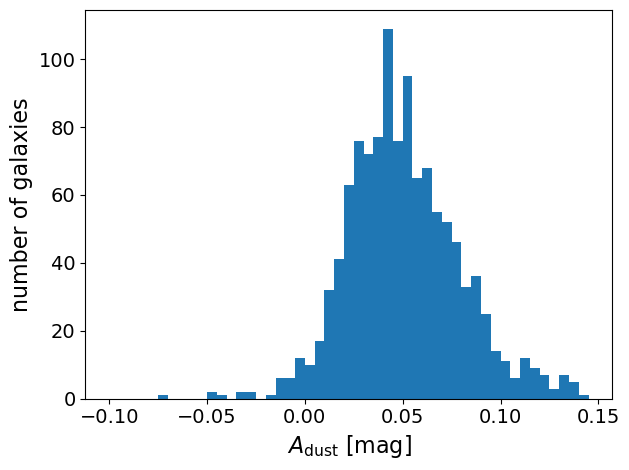

In [13]:
plt.figure(tight_layout=True)

plt.hist(gals['Adust'], bins=np.arange(-0.1, 0.15, 0.005))

plt.xlabel(r'$A_\text{dust}$ [mag]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14);

# plt.savefig('../Figures/SV/fuji_Adust_hist_20240701.png', dpi=150);

## 4. Apply dust correction

In [14]:
if 'R_MAG_SB26_CORR' not in gals.colnames:    
    gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26']
    gals['R_MAG_SB26_CORR_ERR'] = gals['R_MAG_SB26_ERR']
    
# Only adjust those galaxies which have valid corrections
nan_gal = np.isnan(gals['Adust'])
    
gals['R_MAG_SB26_CORR'][~nan_gal] -= gals['Adust'][~nan_gal]
gals['R_MAG_SB26_CORR_ERR'][~nan_gal] = np.sqrt(gals['R_MAG_SB26_CORR_ERR'][~nan_gal]**2 + gals['Adust_err'][~nan_gal]**2)

# Imaging survey systematics

Khaled found that there is a systematic offset in the magnitudes between BASS and DECaLS: 
\begin{equation}
  m_\text{BASS} - m_\text{DECaLS} = 0.0234
\end{equation}
The RMS deviation is 0.02 mag.

To maintain consistency with the FP analysis, we will adjust the northern (i.e., BASS) photometry to match DECaLS.

In [3]:
if 'R_MAG_SB26_CORR' not in gals.colnames:    
    gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26']
    gals['R_MAG_SB26_CORR_ERR'] = gals['R_MAG_SB26_ERR']
    
bass_gal = gals['PHOTSYS'] == 'N'

gals['R_MAG_SB26_CORR'][bass_gal] += 0.0234
gals['R_MAG_SB26_CORR_ERR'][bass_gal] = np.sqrt(gals['R_MAG_SB26_CORR_ERR'][bass_gal]**2 + 0.02**2)

# $K$-correct

In [3]:
filters = ['decam_g', 'decam_r', 'decam_z']
kc = kcorrect.kcorrect.Kcorrect(responses=filters)

In [4]:
def mag2maggies(m):
    '''
    Convert magnitudes to AB maggies
    '''
    return np.power(10, -0.4*m)


def err2ivar(error, maggie):
    '''
    Convert magnitude uncertainties to maggie inverse variances
    '''
    mag_ivar = 1/error**2
    return mag_ivar/np.square(0.4*np.log(10)*maggie)

In [5]:
redshift = gals['Z_DESI']

magnitude = [gals['G_MAG_SB26'], gals['R_MAG_SB26'], gals['Z_MAG_SB26']]
maggies = mag2maggies(np.array(magnitude).T)

mag_errors = [gals['G_MAG_SB26_ERR'], gals['R_MAG_SB26_ERR'], gals['Z_MAG_SB26_ERR']]
ivar = err2ivar(np.array(mag_errors).T, maggies)

In [10]:
maggies[:4]

array([[2.6068454e-07, 4.2690903e-07, 5.9023012e-07],
       [7.4648838e-08, 1.4858620e-07, 2.0758519e-07],
       [7.6511313e-08, 1.1944553e-07, 1.4512882e-07],
       [9.1272318e-07, 1.3646168e-06, 1.8233437e-06]], dtype=float32)

In [7]:
np.median(redshift)

0.0454873733265689

In [8]:
coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

k = kc.kcorrect(redshift=redshift, coeffs=coeffs, band_shift=0.05)

gals['G_Ak'] = k[:,0]
gals['R_Ak'] = k[:,1]
gals['Z_Ak'] = k[:,2]

RuntimeError: Maximum number of iterations reached.

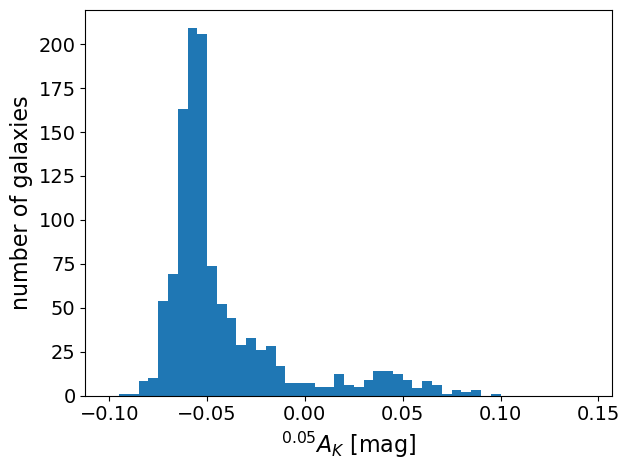

In [9]:
plt.figure(tight_layout=True)

plt.hist(gals['R_Ak'], bins=np.arange(-0.1, 0.15, 0.005))

plt.xlabel(r'$^{0.05}A_K$ [mag]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14);

## Apply $K$-correction

In [10]:
if 'R_MAG_SB26_CORR' not in gals.colnames:
    gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26']
    gals['R_MAG_SB26_CORR_ERR'] = gals['R_MAG_SB26_ERR']
    
gals['R_MAG_SB26_CORR'] += gals['R_Ak']

# Save results to file

In [12]:
gals.write(gals_directory + 'SGA-2020_fuji_Vrot_phot-K-Corr.fits')

OSError: File /global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot_phot-K-Corr.fits already exists. If you mean to replace it then use the argument "overwrite=True".